In [1]:
import optuna
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
from scipy.stats import skew
from collections import Counter

# sklearn
from sklearn.model_selection import (
    cross_val_score, KFold, StratifiedKFold,
    train_test_split, RandomizedSearchCV, GridSearchCV)
from sklearn.metrics import (
    precision_score, recall_score, confusion_matrix, roc_auc_score,
    RocCurveDisplay, accuracy_score, f1_score, classification_report,
    balanced_accuracy_score, fbeta_score, precision_recall_curve, roc_curve, PrecisionRecallDisplay)
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder,
    OrdinalEncoder, PowerTransformer)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')

<br>

### Loading data

In [2]:
# load base data
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

# load age & sex matched data
X_train_matched = pd.read_pickle('X_train_matched.pkl')
X_test_matched = pd.read_pickle('X_test_matched.pkl')
y_train_matched = pd.read_pickle('y_train_matched.pkl')
y_test_matched = pd.read_pickle('y_test_matched.pkl')


n_iterations = 100     # for hyperparmeter tuning
cv_folds = 5           # number of cross validation folds for hyperparameter tuning

<br>

### Scoring metric = ROC AUC

In [ ]:
# base data hyperparameter tuning
def objective(trial):
    # hyperparameters relevant to LGBM
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_bin': trial.suggest_int('max_bin', 128, 1024),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 8, 128),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-3, 1000, log=True),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-4, 10, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 5000),
        'n_jobs': -1,
        'bagging_freq': 1,
        'force_row_wise': True,
        'bagging_seed': 2024,
        'verbosity': -100,
        'extra_trees': False}

    # create model with above parameters
    model = lgb.LGBMClassifier(**params)

    # 5 fold cross validation
    cv = KFold(n_splits = cv_folds, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=1)
    return scores.mean()

# create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_iterations, show_progress_bar=True)

# get the best hyperparameters
print("\nBest hyperparameters found:")
for param, value in study.best_params.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation score: {study.best_value:.4f}")

In [ ]:
# base data model evaluation

# set the optimal hyperparameters found above
base_params = {
    'n_estimators': 368,
    'max_bin': 612,
    'learning_rate': 0.04492929029938169,
    'max_depth': 4,
    'num_leaves': 69,
    'bagging_fraction': 0.8930333984571698,
    'feature_fraction': 0.6723092127660762,
    'lambda_l2': 101.66071203673786,
    'min_sum_hessian_in_leaf': 0.0035990279823698043,
    'min_data_in_leaf': 24,

    # normal params:
    'n_jobs': -1,
    'bagging_freq': 1,
    'force_row_wise': True,
    'bagging_seed': 2024,
    'verbosity': -100,
    'extra_trees': False,
}

# train the final model
base_model = lgb.LGBMClassifier(**base_params)
base_model.fit(X_train, y_train)

# make predictions with test set
y_pred = base_model.predict(X_test)
y_pred_proba = base_model.predict_proba(X_test)[:, 1]

# eval metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUROC: {auroc:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# feature importance
feature_importance = base_model.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature_{i}' for i in range(X_train.shape[1])]
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(5,5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

# ROC curve
plt.figure(figsize=(3,3))
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='0.5')
plt.legend()
plt.show()

# precision recall curve
plt.figure(figsize=(3,3))
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

<br>

In [3]:
# undersampling controls
undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=1)
X_train_smote, y_train_smote = undersampler.fit_resample(X_train, y_train)

print("before undersampling:")
print(y_train.value_counts())
print("\nafter undersampling:")
print(y_train_smote.value_counts())

before undersampling:
Heart_Disease
0    227106
1     19977
Name: count, dtype: int64

after undersampling:
Heart_Disease
0    39954
1    19977
Name: count, dtype: int64


In [ ]:
# undersampled hyperparameter tuning

def objective(trial):
    # hyperparameters relevant to LGBM
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_bin': trial.suggest_int('max_bin', 128, 1024),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 8, 128),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-3, 1000, log=True),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-4, 10, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 5000),
        'n_jobs': -1,
        'bagging_freq': 1,
        'force_row_wise': True,
        'bagging_seed': 2024,
        'verbosity': -100,
        'extra_trees': False}

    # create model with above parameters
    model_smote = lgb.LGBMClassifier(**params)

    # 5 fold cross validation
    cv = KFold(n_splits = cv_folds, shuffle=True, random_state=1)
    scores = cross_val_score(model_smote, X_train_smote, y_train_smote, cv=cv, scoring='roc_auc', n_jobs=1)
    return scores.mean()

# create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_iterations, show_progress_bar=True)

# get the best hyperparameters
print("\nBest hyperparameters found:")
for param, value in study.best_params.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation score: {study.best_value:.4f}")

In [ ]:
# undersampled model evaluation

# set the optimal hyperparameters found above
smote_params = {
    'n_estimators': 381,
    'max_bin': 369,
    'learning_rate': 0.030027550861638556,
    'max_depth': 3,
    'num_leaves': 87,
    'bagging_fraction': 0.9336151881344432,
    'feature_fraction': 0.6670365046716105,
    'lambda_l2': 0.6386045468782642,
    'min_sum_hessian_in_leaf': 0.01048928153287772,
    'min_data_in_leaf': 687,
    
    # normal params:
    'n_jobs': -1,
    'bagging_freq': 1,
    'force_row_wise': True,
    'bagging_seed': 2024,
    'verbosity': -100,
    'extra_trees': False}

# train the final model
smote_model = lgb.LGBMClassifier(**smote_params)
smote_model.fit(X_train_smote, y_train_smote)

# make predictions with test set
y_pred = smote_model.predict(X_test)
y_pred_proba = smote_model.predict_proba(X_test)[:, 1]

# eval metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUROC: {auroc:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# feature importance
feature_importance = smote_model.feature_importances_
feature_names = X_train_smote.columns if hasattr(X_train, 'columns') else [f'Feature_{i}' for i in range(X_train_smote.shape[1])]
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(5,5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

# ROC curve
plt.figure(figsize=(3,3))
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='0.5')
plt.legend()
plt.show()

# precision recall curve
plt.figure(figsize=(3,3))
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

<br>

In [ ]:
# age/sex matched hyperparameter tuning

def objective(trial):
    # hyperparameters relevant to LGBM
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_bin': trial.suggest_int('max_bin', 128, 1024),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 8, 128),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-3, 1000, log=True),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-4, 10, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 5000),
        'n_jobs': -1,
        'bagging_freq': 1,
        'force_row_wise': True,
        'bagging_seed': 2024,
        'verbosity': -100,
        'extra_trees': False}

    # create model with above parameters
    model = lgb.LGBMClassifier(**params)

    # 5 fold cross validation
    cv = KFold(n_splits = cv_folds, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_train_matched, y_train_matched, cv=cv, scoring='roc_auc', n_jobs=1)
    return scores.mean()

# create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_iterations, show_progress_bar=True)

# get the best hyperparameters
print("\nBest hyperparameters found:")
for param, value in study.best_params.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation score: {study.best_value:.4f}")

In [ ]:
# age/sex matched model evaluation

# set the optimal hyperparameters found above
matched_params = {
    'n_estimators': 297,
    'max_bin': 698,
    'learning_rate': 0.03664083987716067,
    'max_depth': 7,
    'num_leaves': 61,
    'bagging_fraction': 0.9609593575826182,
    'feature_fraction': 0.5204793037683734,
    'lambda_l2': 154.4619926699515,
    'min_sum_hessian_in_leaf': 0.004812351346173821,
    'min_data_in_leaf': 2202,

    # normal params:
    'n_jobs': -1,
    'bagging_freq': 1,
    'force_row_wise': True,
    'bagging_seed': 2024,
    'verbosity': -100,
    'extra_trees': False,
}

# train the final model
matched_model = lgb.LGBMClassifier(**matched_params)
matched_model.fit(X_train_matched, y_train_matched)

# make predictions with test set
y_pred = matched_model.predict(X_test_matched)
y_pred_proba = matched_model.predict_proba(X_test_matched)[:, 1]

# eval metrics
precision = precision_score(y_test_matched, y_pred)
recall = recall_score(y_test_matched, y_pred)
conf_matrix = confusion_matrix(y_test_matched, y_pred)
auroc = roc_auc_score(y_test_matched, y_pred_proba)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUROC: {auroc:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# feature importance
feature_importance = matched_model.feature_importances_
feature_names = X_train_matched.columns if hasattr(X_train_matched, 'columns') else [f'Feature_{i}' for i in range(X_train_matched.shape[1])]
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(5,5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

# ROC curve
plt.figure(figsize=(3,3))
RocCurveDisplay.from_predictions(y_test_matched, y_pred_proba)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='0.5')
plt.legend()
plt.show()

# precision recall curve
plt.figure(figsize=(3,3))
PrecisionRecallDisplay.from_predictions(y_test_matched, y_pred_proba)
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

<br>

### Scoring metric = Recall

In [ ]:
# base data hyperparameter tuning

def objective(trial):
    # hyperparameters relevant to LGBM
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_bin': trial.suggest_int('max_bin', 128, 1024),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 8, 128),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-3, 1000, log=True),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-4, 10, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 5000),
        'n_jobs': -1,
        'bagging_freq': 1,
        'force_row_wise': True,
        'bagging_seed': 2024,
        'verbosity': -100,
        'extra_trees': False}

    # create model with above parameters
    model = lgb.LGBMClassifier(**params)

    # 5 fold cross validation
    cv = KFold(n_splits = cv_folds, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall', n_jobs=1)
    return scores.mean()

# create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_iterations, show_progress_bar=True)

# get the best hyperparameters
print("\nBest hyperparameters found:")
for param, value in study.best_params.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation score: {study.best_value:.4f}")

In [ ]:
# base data model evaluation

# set the optimal hyperparameters found above
base_params = {
    'n_estimators': 299,
    'max_bin': 352,
    'learning_rate': 0.2997976527843294,
    'max_depth': 9,
    'num_leaves': 105,
    'bagging_fraction': 0.8152704911597977,
    'feature_fraction': 0.8378133204831323,
    'lambda_l2': 1.4869979936367044,
    'min_sum_hessian_in_leaf': 0.4590025239961025,
    'min_data_in_leaf': 261,

    # normal params:
    'n_jobs': -1,
    'bagging_freq': 1,
    'force_row_wise': True,
    'bagging_seed': 2024,
    'verbosity': -100,
    'extra_trees': False,
}

# train the final model
base_model = lgb.LGBMClassifier(**base_params)
base_model.fit(X_train, y_train)

# make predictions with test set
y_pred = base_model.predict(X_test)
y_pred_proba = base_model.predict_proba(X_test)[:, 1]

# eval metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUROC: {auroc:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# feature importance
feature_importance = base_model.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature_{i}' for i in range(X_train.shape[1])]
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(5,5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

# ROC curve
plt.figure(figsize=(3,3))
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='0.5')
plt.legend()
plt.show()

# precision recall curve
plt.figure(figsize=(3,3))
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

<br>

In [ ]:
# undersampled hyperparameter tuning

def objective(trial):
    # hyperparameters relevant to LGBM
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_bin': trial.suggest_int('max_bin', 128, 1024),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 8, 128),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-3, 1000, log=True),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-4, 10, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 5000),
        'n_jobs': -1,
        'bagging_freq': 1,
        'force_row_wise': True,
        'bagging_seed': 2024,
        'verbosity': -100,
        'extra_trees': False}

    # create model with above parameters
    model_smote = lgb.LGBMClassifier(**params)

    # 5 fold cross validation
    cv = KFold(n_splits = cv_folds, shuffle=True, random_state=1)
    scores = cross_val_score(model_smote, X_train_smote, y_train_smote, cv=cv, scoring='recall', n_jobs=1)
    return scores.mean()

# create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_iterations, show_progress_bar=True)

# get the best hyperparameters
print("\nBest hyperparameters found:")
for param, value in study.best_params.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation score: {study.best_value:.4f}")

Precision: 0.2535
Recall: 0.6209
AUROC: 0.8323
Accuracy: 0.8215

Confusion Matrix 
TN FP 
FN TP:
[[47645  9132]
 [ 1893  3101]]


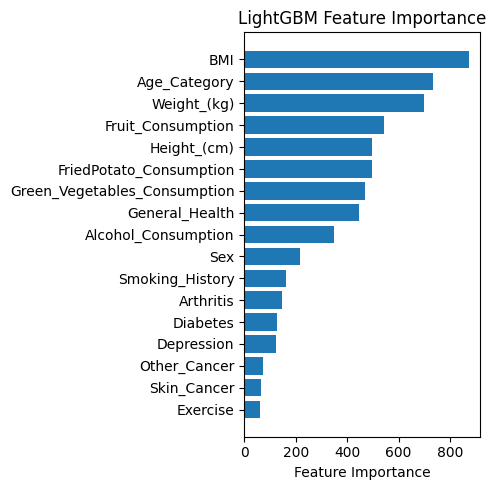

<Figure size 300x300 with 0 Axes>

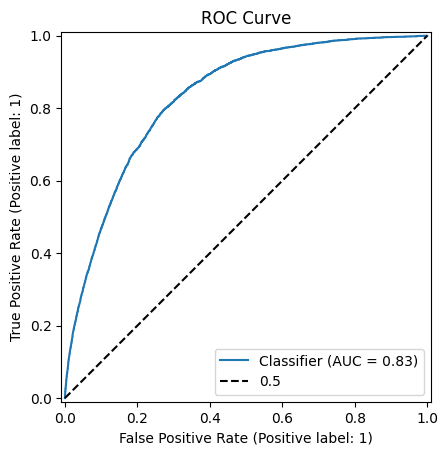

<Figure size 300x300 with 0 Axes>

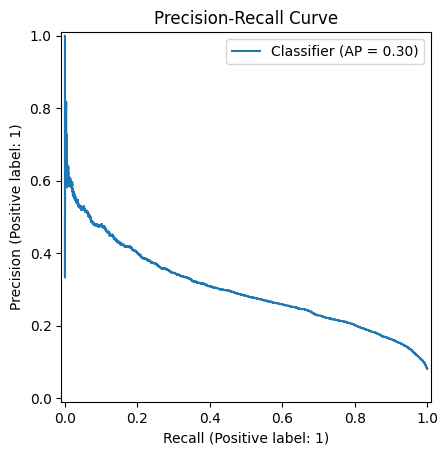

In [5]:
# undersampled model evaluation

# set the optimal hyperparameters found above
smote_params = {
    'n_estimators': 316,
    'max_bin': 155,
    'learning_rate': 0.09157073221081566,
    'max_depth': 8,
    'num_leaves': 71,
    'bagging_fraction': 0.8910733061393177,
    'feature_fraction': 0.8656518984470933,
    'lambda_l2': 993.4066861978613,
    'min_sum_hessian_in_leaf': 0.45634063289049837,
    'min_data_in_leaf': 1095,
    
    # normal params:
    'n_jobs': -1,
    'bagging_freq': 1,
    'force_row_wise': True,
    'bagging_seed': 2024,
    'verbosity': -100,
    'extra_trees': False}

# train the final model
smote_model = lgb.LGBMClassifier(**smote_params)
smote_model.fit(X_train_smote, y_train_smote)

# make predictions with test set
y_pred = smote_model.predict(X_test)
y_pred_proba = smote_model.predict_proba(X_test)[:, 1]

# eval metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUROC: {auroc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# feature importance
feature_importance = smote_model.feature_importances_
feature_names = X_train_smote.columns if hasattr(X_train_smote, 'columns') else [f'Feature_{i}' for i in range(X_train_smote.shape[1])]
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(5,5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

# ROC curve
plt.figure(figsize=(3,3))
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='0.5')
plt.legend()
plt.show()

# precision recall curve
plt.figure(figsize=(3,3))
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

<br>

In [ ]:
# age/sex matched hyperparameter tuning

def objective(trial):
    # hyperparameters relevant to LGBM
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_bin': trial.suggest_int('max_bin', 128, 1024),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 8, 128),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-3, 1000, log=True),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-4, 10, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 5000),
        'n_jobs': -1,
        'bagging_freq': 1,
        'force_row_wise': True,
        'bagging_seed': 2024,
        'verbosity': -100,
        'extra_trees': False}

    # create model with above parameters
    model = lgb.LGBMClassifier(**params)

    # 5 fold cross validation
    cv = KFold(n_splits = cv_folds, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_train_matched, y_train_matched, cv=cv, scoring='recall', n_jobs=1)
    return scores.mean()

# create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_iterations, show_progress_bar=True)

# get the best hyperparameters
print("\nBest hyperparameters found:")
for param, value in study.best_params.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation score: {study.best_value:.4f}")

In [ ]:
# age/sex matched model evaluation

# set the optimal hyperparameters found above
matched_params = {
    'n_estimators': 312,
    'max_bin': 733,
    'learning_rate': 0.28642682596893726,
    'max_depth': 12,
    'num_leaves': 123,
    'bagging_fraction': 0.6412630511112203,
    'feature_fraction': 0.7374540315935075,
    'lambda_l2': 0.6432538398292775,
    'min_sum_hessian_in_leaf': 1.1693341208203987,
    'min_data_in_leaf': 324,

    # normal params:
    'n_jobs': -1,
    'bagging_freq': 1,
    'force_row_wise': True,
    'bagging_seed': 2024,
    'verbosity': -100,
    'extra_trees': False,
}

# train the final model
matched_model = lgb.LGBMClassifier(**matched_params)
matched_model.fit(X_train_matched, y_train_matched)

# make predictions with test set
y_pred = matched_model.predict(X_test_matched)
y_pred_proba = matched_model.predict_proba(X_test_matched)[:, 1]

# eval metrics
precision = precision_score(y_test_matched, y_pred)
recall = recall_score(y_test_matched, y_pred)
conf_matrix = confusion_matrix(y_test_matched, y_pred)
auroc = roc_auc_score(y_test_matched, y_pred_proba)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUROC: {auroc:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# feature importance
feature_importance = matched_model.feature_importances_
feature_names = X_train_matched.columns if hasattr(X_train_matched, 'columns') else [f'Feature_{i}' for i in range(X_train_matched.shape[1])]
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(5,5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

# ROC curve
plt.figure(figsize=(3,3))
RocCurveDisplay.from_predictions(y_test_matched, y_pred_proba)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='0.5')
plt.legend()
plt.show()

# precision recall curve
plt.figure(figsize=(3,3))
PrecisionRecallDisplay.from_predictions(y_test_matched, y_pred_proba)
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

<br>

In [3]:
# over and undersample to get a 50/50 distribution
original_counts = Counter(y_train)
cases = min(original_counts, key=original_counts.get)
controls = max(original_counts, key=original_counts.get)
cases_count = original_counts[cases]
controls_count = original_counts[controls]

print('Before sampling:', y_train.value_counts())
target_size = cases_count * 2

# oversample cases
random_oversampler = RandomOverSampler(sampling_strategy={cases: target_size}, random_state=1)
X_oversampled, y_oversampled = random_oversampler.fit_resample(X_train, y_train)

# undersample controls
undersampler = RandomUnderSampler(sampling_strategy={controls: target_size}, random_state=1)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_oversampled, y_oversampled)

print('\nFinal distribution:', y_train_balanced.value_counts())

Before sampling: Heart_Disease
0    227106
1     19977
Name: count, dtype: int64

Final distribution: Heart_Disease
0    39954
1    39954
Name: count, dtype: int64


In [4]:
# 50/50 hyperparameter tuning

def objective(trial):
    # hyperparameters relevant to LGBM
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_bin': trial.suggest_int('max_bin', 128, 1024),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 8, 128),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-3, 1000, log=True),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-4, 10, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 5000),
        'n_jobs': -1,
        'bagging_freq': 1,
        'force_row_wise': True,
        'bagging_seed': 2024,
        'verbosity': -100,
        'extra_trees': False}

    # create model with above parameters
    model = lgb.LGBMClassifier(**params)

    # 5 fold cross validation
    cv = KFold(n_splits = cv_folds, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=cv, scoring='recall', n_jobs=1)
    return scores.mean()

# create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_iterations, show_progress_bar=True)

# get the best hyperparameters
print("\nBest hyperparameters found:")
for param, value in study.best_params.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation score: {study.best_value:.4f}")

[I 2025-10-12 05:20:15,398] A new study created in memory with name: no-name-784b8f33-94ae-43bf-b434-6e2e0ca502db


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-12 05:20:16,925] Trial 0 finished with value: 0.8024829219013746 and parameters: {'n_estimators': 60, 'max_bin': 839, 'learning_rate': 0.08518070194338791, 'max_depth': 7, 'num_leaves': 45, 'bagging_fraction': 0.9351347270301018, 'feature_fraction': 0.5055154672217248, 'lambda_l2': 36.73775075043002, 'min_sum_hessian_in_leaf': 0.2890576386768435, 'min_data_in_leaf': 1709}. Best is trial 0 with value: 0.8024829219013746.
[I 2025-10-12 05:20:24,682] Trial 1 finished with value: 0.809262006479406 and parameters: {'n_estimators': 222, 'max_bin': 1004, 'learning_rate': 0.0016310956565622075, 'max_depth': 10, 'num_leaves': 83, 'bagging_fraction': 0.7773134214200508, 'feature_fraction': 0.7021994474990532, 'lambda_l2': 0.2756164038637265, 'min_sum_hessian_in_leaf': 0.9944701690375014, 'min_data_in_leaf': 752}. Best is trial 1 with value: 0.809262006479406.
[I 2025-10-12 05:20:29,703] Trial 2 finished with value: 0.8071555239333209 and parameters: {'n_estimators': 317, 'max_bin': 69

Precision: 0.2036
Recall: 0.7353
AUROC: 0.8144
Accuracy: 0.7461

Confusion Matrix 
TN FP 
FN TP:
[[42416 14361]
 [ 1322  3672]]


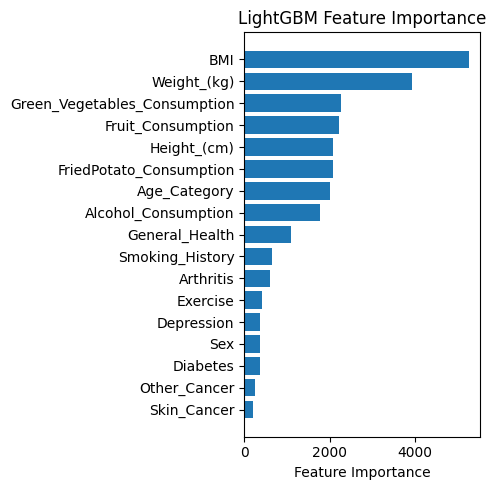

<Figure size 300x300 with 0 Axes>

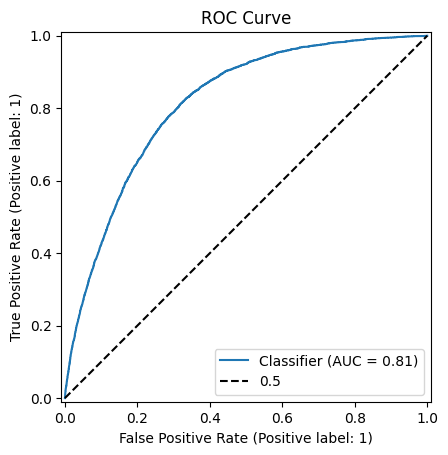

<Figure size 300x300 with 0 Axes>

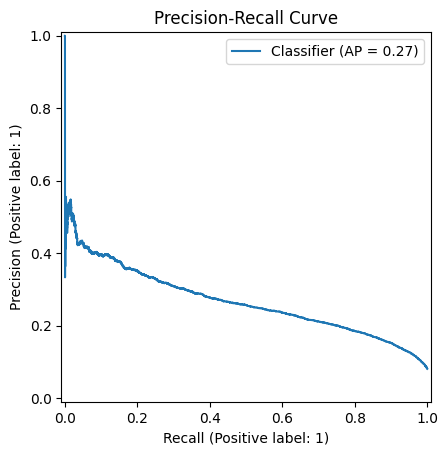

In [6]:
# 50/50 model evaluation

# set the optimal hyperparameters found above
params = {
    'n_estimators': 475,
    'max_bin': 929,
    'learning_rate': 0.1158242211405467,
    'max_depth': 11,
    'num_leaves': 56,
    'bagging_fraction': 0.7009066213123843,
    'feature_fraction': 0.8298374593325589,
    'lambda_l2': 0.0010015907387817217,
    'min_sum_hessian_in_leaf': 0.5761462555260555,
    'min_data_in_leaf': 149,
    
    # normal params:
    'n_jobs': -1,
    'bagging_freq': 1,
    'force_row_wise': True,
    'bagging_seed': 2024,
    'verbosity': -100,
    'extra_trees': False}

# train the final model
model = lgb.LGBMClassifier(**params)
model.fit(X_train_balanced, y_train_balanced)

# make predictions with test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# eval metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUROC: {auroc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# feature importance
feature_importance = model.feature_importances_
feature_names = X_train_balanced.columns if hasattr(X_train_balanced, 'columns') else [f'Feature_{i}' for i in range(X_train_balanced.shape[1])]
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(5,5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

# ROC curve
plt.figure(figsize=(3,3))
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='0.5')
plt.legend()
plt.show()

# precision recall curve
plt.figure(figsize=(3,3))
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()